In [2]:
import rosbag
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import numpy as np
import struct

import tams_pr2_guzheng

In [3]:
import rospy
rospy.init_node('jupyter_lab')

import audio_common_msgs.msg
audio_pub= rospy.Publisher('guzheng/audio', audio_common_msgs.msg.AudioData, queue_size=10)

In [4]:
def big_plot():
    plt.figure(figsize=(15,8), dpi=100)

def plot_audio(e):
    cqt = np.log(np.array(e.cqt.data).reshape((-1,e.cqt.number_of_semitones))).T
    #plt.imshow(cqt, cmap='jet')
    plt.grid(False)
    
    X= np.tile(np.arange(84).T[:,np.newaxis], cqt.shape[1])
    Y= np.tile((np.arange(cqt.shape[1])*512/44100 + (e.cqt.header.stamp - e.start_execution).to_sec()+magic_cqt_offset)[:, np.newaxis], cqt.shape[0]).T
    
    plt.pcolormesh(Y, X, cqt, cmap='jet')
    
    plt.vlines([(o.header.stamp-e.start_execution).to_sec()+magic_cqt_offset for o in e.detected_audio_onsets], ymin=0, ymax= 84, color=(1.0,0,1.0,0.8))
    plt.vlines([(o-e.start_execution).to_sec() for o in e.detected_tactile_plucks], ymin=0-4, ymax= 84+4, color='red')

def plot_raw_audio(e):
    signal = np.array(struct.unpack('{0}h'.format(int(len(e.audio_data.audio.data)/2)), e.audio_data.audio.data), dtype=float)
    
    plt.plot(np.arange(len(signal), dtype=float)/e.audio_info.sample_rate+e.audio_data.header.stamp.to_sec() - e.start_execution.to_sec(), signal)

    vmin = np.min(signal)*1.05
    vmax = np.max(signal)*1.05

    plt.vlines([(o.header.stamp - e.start_execution).to_sec()+magic_cqt_offset for o in e.detected_audio_onsets], ymin=vmin, ymax=vmax, color='purple')
    plt.vlines([o.to_sec() - e.start_execution.to_sec() for o in e.detected_tactile_plucks], ymin=vmin, ymax= vmax, color='red')

def plot_tactile(e):
    plt.plot([t.header.stamp.to_sec()-e.start_execution.to_sec() for t in e.tactile_data],[t.tactile.pdc for t in e.tactile_data])
    vmin = np.min([t.tactile.pdc for t in e.tactile_data])
    vmax = np.max([t.tactile.pdc for t in e.tactile_data])
    delta = (vmax - vmin)*0.05
    vmin = vmin - delta
    vmax = vmax + delta
    plt.vlines([o.header.stamp.to_sec()-e.start_execution.to_sec()+magic_cqt_offset for o in e.detected_audio_onsets],
               vmin,
               vmax,
               'purple')
    plt.vlines([o.to_sec()-e.start_execution.to_sec() for o in e.detected_tactile_plucks],
               vmin,
               vmax, 'red')

def plot_tactile_ac(e):
    plt.plot([t.header.stamp.to_sec()-e.start_execution.to_sec() for t in e.tactile_data],[t.tactile.pac0 for t in e.tactile_data])
    vmin = np.min([t.tactile.pac0 for t in e.tactile_data])
    vmax = np.max([t.tactile.pac0 for t in e.tactile_data])
    delta = (vmax - vmin)*0.05
    vmin = vmin - delta
    vmax = vmax + delta
    plt.vlines([o.header.stamp.to_sec()-e.start_execution.to_sec()+magic_cqt_offset for o in e.detected_audio_onsets],
               vmin,
               vmax,
               'purple')
    plt.vlines([o.to_sec()-e.start_execution.to_sec() for o in e.detected_tactile_plucks],
               vmin,
               vmax, 'red')

    
def plot_joint(e, joint):
    j_idx = e.executed_trajectory.joint_names.index(joint)
    sample_times = [p.time_from_start.to_sec()-e.start_execution.to_sec() for p in e.executed_trajectory.points]+[(e.header.stamp+e.length).to_sec()]
    sample_pos = [p.positions[j_idx] for p in e.executed_trajectory.points]+[e.executed_trajectory.points[-1].positions[j_idx]]
    plt.plot(sample_times, sample_pos, color='b')
    
    vmin = np.min(sample_pos)
    vmax = np.max(sample_pos)
    delta = (vmax - vmin)*0.5
    vmin = vmin - delta
    vmax = vmax + delta
    plt.vlines([o.header.stamp.to_sec()-e.start_execution.to_sec()+magic_cqt_offset for o in e.detected_audio_onsets],
               vmin,
               vmax,
               'purple')
    plt.vlines([o.to_sec()-e.start_execution.to_sec() for o in e.detected_tactile_plucks],
               vmin,
               vmax, 'red')
    
# requires `roslaunch tams_pr2_guzheng play_audio_topic.launch`
def play_audio(e):
    audio_pub.publish(e.audio_data.audio)

def cqt_from_episode(e):
    return np.array(e.cqt.data).reshape((-1,e.cqt.number_of_semitones))

In [5]:
from functools import reduce
guzheng_range = reduce(lambda a,b: a+b, list(map(lambda o: [f"{n}{o}" for n in ["d", "e", "fis", "a", "b"]], range(2, 6)))) + ["d6"]
cqt_range = reduce(lambda a,b: a+b, list(map(lambda o: [f"{n}{o}" for n in ["c", "cis", "d", "dis", "e", "f", "fis", "g", "gis", "a", "ais", "b"]], range(2, 8)))) + ["c8"]

In [6]:
bag_name = '../../../../bags/20220912_recording/guzheng_d6_2022-09-12-20-04-16_extracted_episodes.bag'
bag = rosbag.Bag(bag_name)
episodes_full_bag = [m for t,m,_ in bag.read_messages()]

In [7]:
magic_cqt_offset = 0.0

In [8]:
target_strings= {e.string for e in episodes_full_bag}
print(f"targeted strings in bag: {target_strings}")
note = "_".join(target_strings)
#note = "fis5"

targeted strings in bag: {'d6'}


In [9]:
note_bucket = cqt_range.index(note)
print(f'target bucket in cqt is {note_bucket}')

target bucket in cqt is 50


In [10]:
#note = "d6_5repeats"

In [11]:
# possibly limit to single note
# note= 'fis5'

episodes_all = [e for e in episodes_full_bag if e.string == note]
#episodes_all = episodes_full_bag
episodes = episodes_all

In [12]:
# assume unique IDs (overwhelmingly likely, but if wrong we might want to know)
assert len({e.id for e in episodes}) == len(episodes)

In [13]:
# drop invalid samples
episodes_valid= [e for e in episodes_all if len(e.detected_audio_onsets) == 0 or len(e.detected_audio_onsets) > 0 and e.start_execution < e.detected_audio_onsets[0].header.stamp]

In [14]:
episodes = episodes_valid
episodes_with_onset = [e for e in episodes if len(e.detected_audio_onsets) > 0]
episodes_with_one_onset = [e for e in episodes if len(e.detected_audio_onsets) == 1]
episodes_with_no_onset = [e for e in episodes if len(e.detected_audio_onsets) == 0]
episodes_with_two_onsets = [e for e in episodes if len(e.detected_audio_onsets) == 2]
episodes_with_many_onsets = [e for e in episodes if len(e.detected_audio_onsets) > 2]

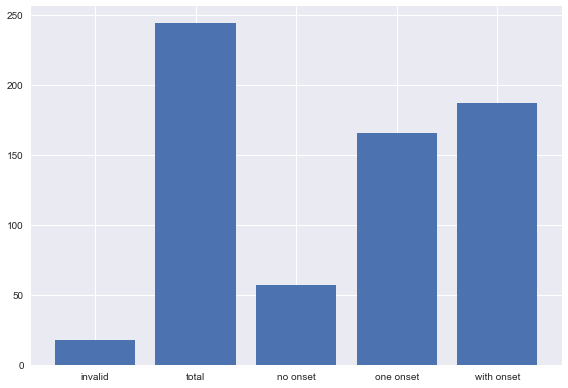

In [15]:
plt.bar(
    np.arange(5),
    [len(episodes_all)-len(episodes_valid), len(episodes), len(episodes_with_no_onset), len(episodes_with_one_onset), len(episodes)-len(episodes_with_no_onset)],
tick_label= ["invalid", "total", "no onset", "one onset", "with onset"]
    )
plt.tight_layout()


In [16]:
len(episodes)

244

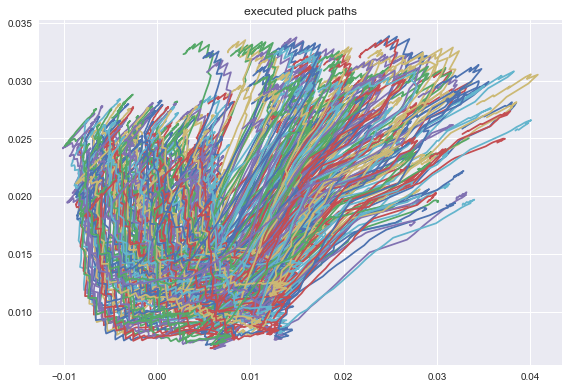

In [17]:
plt.title('executed pluck paths')
for i, e in enumerate(episodes):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses])
plt.tight_layout()

In [18]:
# plt.figure(figsize=(20,10))
# ax = plt.subplot(1,2,1)

# e = episodes[95]
# plt.gca().set_aspect('equal', 'box')
# #plt.title('executed vs commanded pluck paths')
# plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color='b')
# plt.plot([-p.pose.position.y for p in e.planned_path.poses], [p.pose.position.z for p in e.planned_path.poses], color='g')
# plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='r')
# plt.savefig(f'finger_trajectories_{e.string}_{e.id}', dpi= 150)

# plt.subplot(1,2,2, sharex=ax, sharey= ax)
# plt.gca().set_aspect('equal', 'box')
# for i, e in enumerate(episodes):
#     plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color= plt.get_cmap('gist_rainbow')((i//5)/20))

    
# plt.tight_layout()

# plt.savefig(f"executed_trajectories_by_parameters_d6_repeat5.png", dpi= 300)

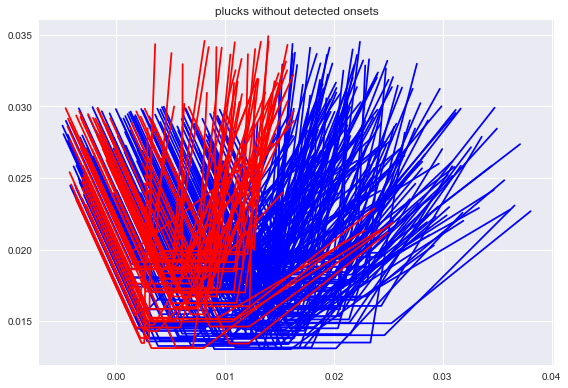

In [19]:
plt.title('plucks without detected onsets')

for e in episodes_with_onset:
    plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='b')

for e in episodes_with_no_onset:
    plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='r')
    
#for e in episodes_with_two_onsets:
#    plt.plot([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='g')

plt.tight_layout()
plt.savefig(f'plucks_hit_missed_{note}', dpi=150)

37 in 46 - id 535354465


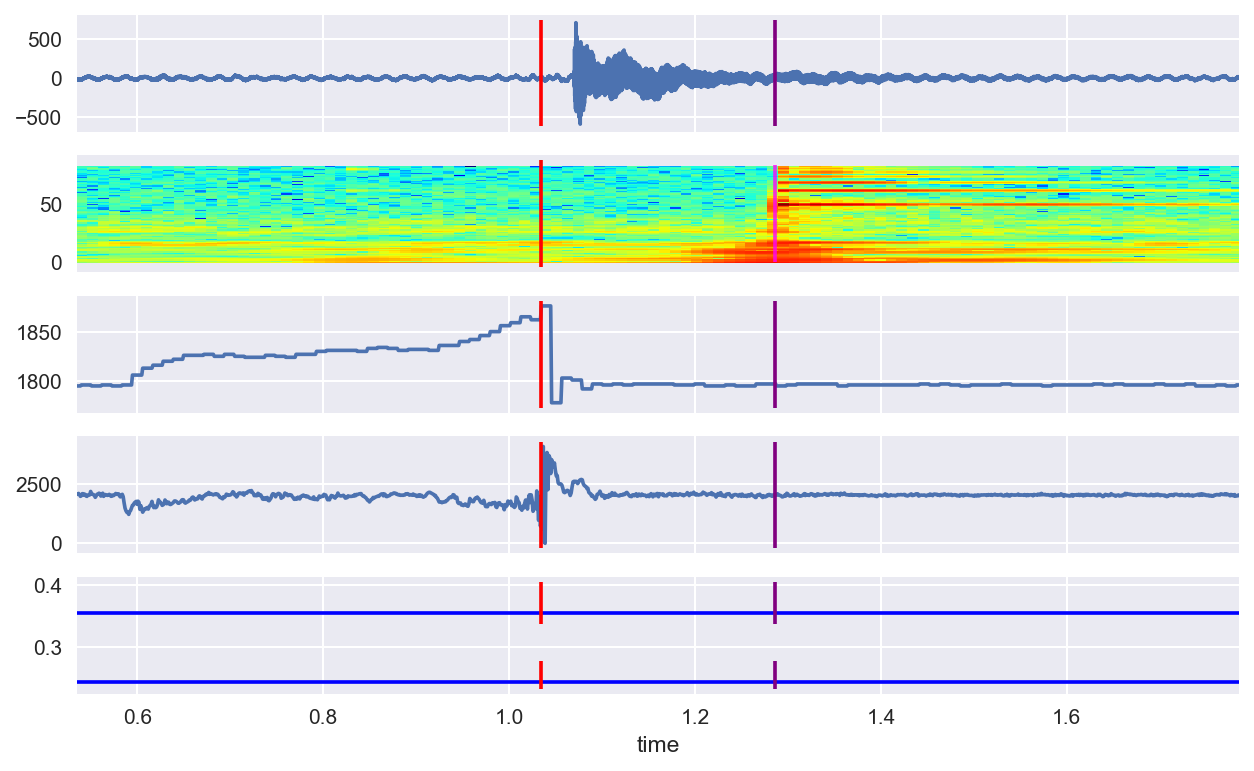

In [20]:
#for i in range(int(len(episodes_with_onset)/4)):
for i in [37]:
    try:
        e= episodes_with_onset[i]
    except:
        e= episodes_with_onset[0]
    print(f'{i} in {int(len(episodes_with_onset)/4)} - id {e.id}')
    
    if len(e.detected_audio_onsets) == 0 or len(e.detected_tactile_plucks) == 0:
        continue

    plt.figure(figsize=(10,6), dpi=150)
    
    N= 5
    
    ax = plt.subplot(N,1,1)
    plot_raw_audio(e)
    context= 0.5
    plt.xlim(e.detected_tactile_plucks[0].to_sec()-context - e.start_execution.to_sec(), e.detected_audio_onsets[-1].header.stamp.to_sec()-e.start_execution.to_sec()+magic_cqt_offset+context)

    ax = plt.subplot(N,1,2, sharex=ax)
    plot_audio(e)

    ax = plt.subplot(N,1,3, sharex=ax)
    plot_tactile(e)

    ax = plt.subplot(N,1,4, sharex=ax)
    plot_tactile_ac(e)
    
    ax = plt.subplot(N,1,5, sharex=ax)
    plot_joint(e, "rh_FFJ2")
    plot_joint(e, "rh_FFJ3")
    plt.xlabel('time')

    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass

    #plt.savefig(f'samples/sample_{e.id}', dpi= 300)

In [21]:
aps= [e.action_parameters.action_parameters for e in episodes]

In [22]:
[i for i,e in enumerate(episodes) if e.id == 110098959]

[243]

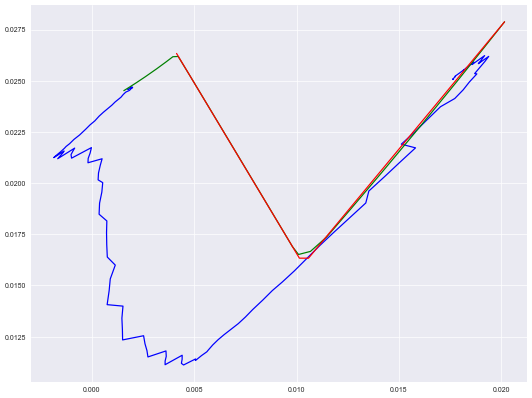

In [23]:
try:
    e = episodes[240]
except:
    e = episodes[1]
    
e = episodes[95]

plt.figure(figsize=(15, 10), dpi=50)
plt.gca().set_aspect('equal', 'box')
#plt.title('executed vs commanded pluck paths')
plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color='b')
plt.plot([-p.pose.position.y for p in e.planned_path.poses], [p.pose.position.z for p in e.planned_path.poses], color='g')
plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='r')
plt.savefig(f'finger_trajectories_{e.string}_{e.id}', dpi= 150)

In [24]:
right_arm_executed_indices = [i for i, n in enumerate(e.executed_trajectory.joint_names) if n in {'r_shoulder_pan_joint','r_shoulder_lift_joint','r_upper_arm_roll_joint','r_elbow_flex_joint','r_forearm_roll_joint','rh_WRJ2','rh_WRJ1'}]

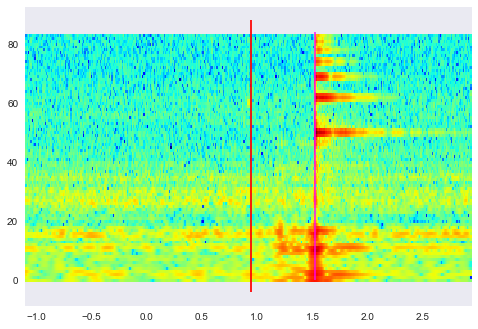

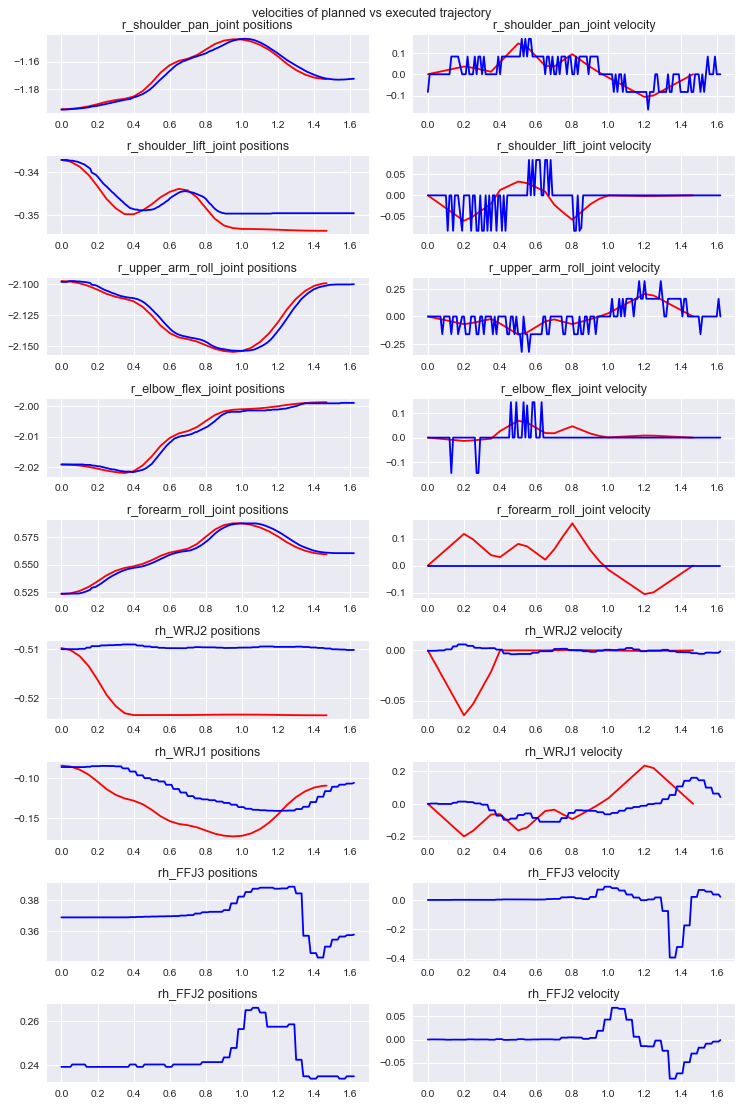

In [25]:
e= episodes_valid[15]

plot_audio(e)

plt.figure(figsize=(10,15), dpi=75)
plt.suptitle('velocities of planned vs executed trajectory')
ax_p = None
ax_v = None
for i in range(7):
    ax_p = plt.subplot(9, 2, 2*(i+1)-1)
    plt.title(f"{e.executed_trajectory.joint_names[right_arm_executed_indices[i]]} positions")
    plt.plot([p.time_from_start.to_sec() for p in e.planned_trajectory.points], [p.positions[i] for p in e.planned_trajectory.points], color='r')
    plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.positions[right_arm_executed_indices[i]] for p in e.executed_trajectory.points], color='b')
    
    plt.subplot(9, 2, 2*(i+1))
    plt.title(f"{e.executed_trajectory.joint_names[right_arm_executed_indices[i]]} velocity")
    plt.plot([p.time_from_start.to_sec() for p in e.planned_trajectory.points], [p.velocities[i] for p in e.planned_trajectory.points], color='r')
    plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.velocities[right_arm_executed_indices[i]] for p in e.executed_trajectory.points], color='b')


ax_p = plt.subplot(9, 2, 15)
j= "rh_FFJ3"
j_idx = e.executed_trajectory.joint_names.index(j)
plt.title(f"{j} positions")
plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.positions[j_idx] for p in e.executed_trajectory.points], color='b')
    
plt.subplot(9, 2, 16)
plt.title(f"{j} velocity")
plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.velocities[j_idx] for p in e.executed_trajectory.points], color='b')

ax_p = plt.subplot(9, 2, 17)
j= "rh_FFJ2"
j_idx = e.executed_trajectory.joint_names.index(j)
plt.title(f"{j} positions")
plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.positions[j_idx] for p in e.executed_trajectory.points], color='b')
    
plt.subplot(9, 2, 18)
plt.title(f"{j} velocity")
plt.plot([p.time_from_start.to_sec() for p in e.executed_trajectory.points], [p.velocities[j_idx] for p in e.executed_trajectory.points], color='b')

plt.tight_layout()
plt.savefig(f'joint_trajectory_{note}_{e.id}.png', dpi= 150)

In [26]:
e_avg_sample_dt= ((e.executed_trajectory.points[-1].time_from_start - e.executed_trajectory.points[0].time_from_start)/len(e.executed_trajectory.points)).to_sec()
print(f'executed trajectory sampled at {1/e_avg_sample_dt}')

executed trajectory sampled at 100.61440184486568


In [27]:
e.length.to_sec()

2.038986313

In [28]:
e.finger

'ff'

In [29]:
e.string

'd6'

In [30]:
e.string_head_frame

header: 
  seq: 0
  stamp: 
    secs: 1663005960
    nsecs: 780417681
  frame_id: "base_footprint"
child_frame_id: "guzheng/d6/head"
transform: 
  translation: 
    x: 0.4657197594642639
    y: -0.4629703462123871
    z: 0.6452648043632507
  rotation: 
    x: 0.07216652482748032
    y: -0.08610279858112335
    z: 0.7575658559799194
    w: 0.6430181264877319

In [31]:
e.finger_start_pose

header: 
  seq: 0
  stamp: 
    secs: 1663005956
    nsecs: 761200190
  frame_id: "guzheng/d6/head"
pose: 
  position: 
    x: 0.05273384000486053
    y: -0.004300277727949164
    z: 0.02270255080947947
  orientation: 
    x: 0.48099822181656227
    y: 0.5339264493832853
    z: -0.565464990875727
    w: 0.40473773943102237

(array([ 3.,  7.,  6., 23., 50., 44., 39., 47., 19.,  6.]),
 array([1.18455172, 1.23048122, 1.27641072, 1.32234023, 1.36826973,
        1.41419923, 1.46012874, 1.50605824, 1.55198774, 1.59791725,
        1.64384675]),
 <BarContainer object of 10 artists>)

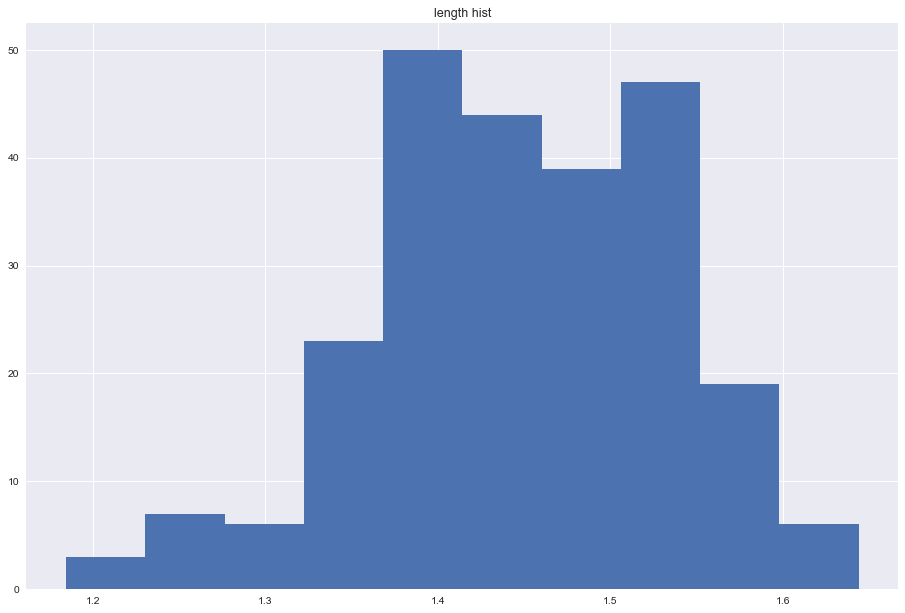

In [32]:
plt.figure(figsize=(15,10), dpi=75)
plt.title('length hist')
plt.hist([e.header.stamp.to_sec() + e.length.to_sec() - e.start_execution.to_sec() for e in episodes])

(array([ 3.,  7.,  6., 23., 50., 44., 39., 47., 19.,  6.]),
 array([1.18455173, 1.23048124, 1.27641074, 1.32234025, 1.36826975,
        1.41419926, 1.46012876, 1.50605827, 1.55198778, 1.59791728,
        1.64384679]),
 <BarContainer object of 10 artists>)

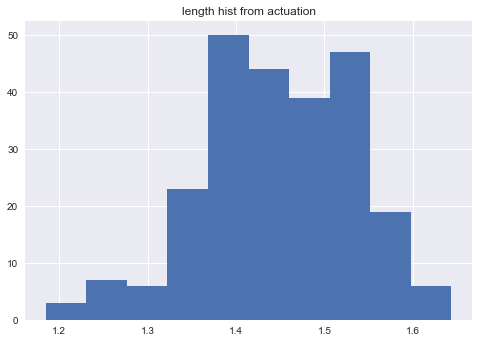

In [33]:
plt.title('length hist from actuation')
plt.hist([(e.header.stamp + e.length - e.start_execution).to_sec() for e in episodes])

(0.0, 1.8)

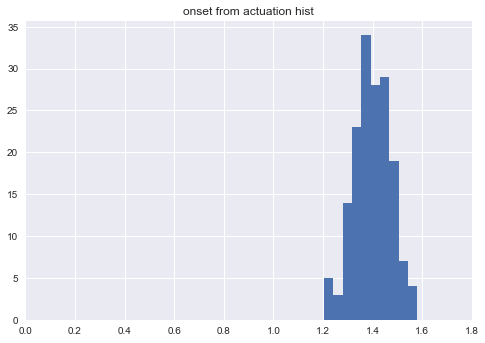

In [34]:
plt.title('onset from actuation hist')
onsets_from_start_execution= [(e.detected_audio_onsets[0].header.stamp - e.start_execution).to_sec() for e in episodes_with_one_onset]
onsets_from_start_execution= [o for o in onsets_from_start_execution if o > 0]
plt.hist(onsets_from_start_execution);
plt.xlim(0, 1.8)
#plt.violinplot()

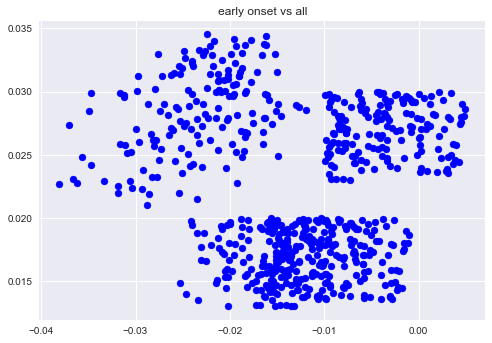

In [35]:
plt.title('early onset vs all')

for e in episodes_with_one_onset:
    plt.scatter([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color= 'b')

episodes_with_early_onset= [e for e in episodes_with_one_onset if e.detected_audio_onsets[0].header.stamp - e.start_execution < rospy.Duration(0.9)]
for e in episodes_with_early_onset:
    plt.plot([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], 'r')

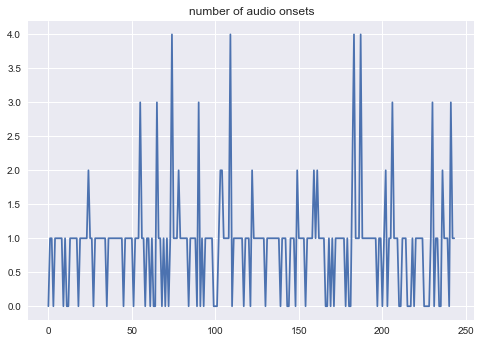

In [36]:
plt.title('number of audio onsets')
plt.plot([len(e.detected_audio_onsets) for e in episodes])

In [37]:
episodes_with_4_onsets = [e for e in episodes if len(e.detected_audio_onsets) == 4]

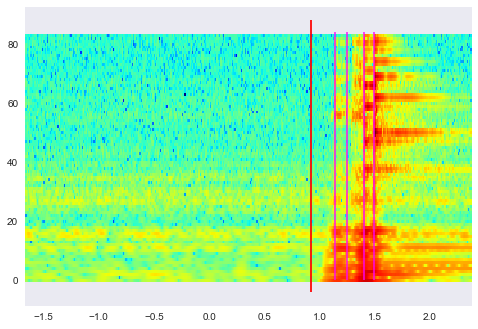

In [38]:
#big_plot()
if len(episodes_with_4_onsets) > 0:
    plot_audio(episodes_with_4_onsets[0])
    #play_audio(episodes_with_4_onsets[0])

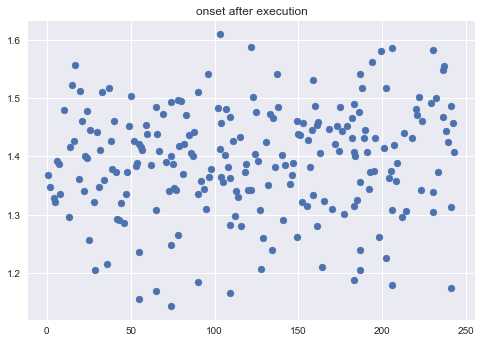

In [39]:
i = 0
plt.title('onset after execution')
onsets = []
for e in episodes:
    for o in e.detected_audio_onsets:
        #if len(onsets) > 1:
        onsets.append((i, (o.header.stamp - e.start_execution).to_sec()))
        #    print(i)
    i+= 1
plt.scatter([i for i,o in onsets], [o for i,o in onsets])

In [40]:
print(f"experiment ran for {(episodes[-1].header.stamp - episodes[0].header.stamp).to_sec()/60} minutes")

experiment ran for 27.545673064383333 minutes


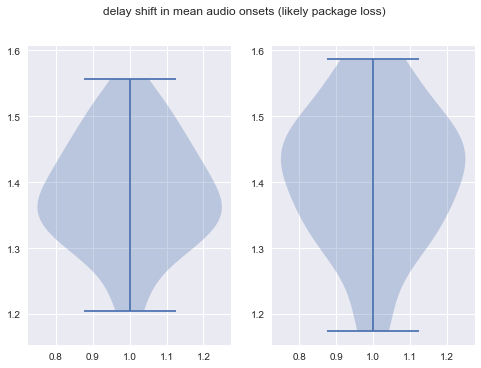

In [41]:
i_early = 50
i_late = len(episodes)-50
onsets_early = [o for i, o in onsets if i < i_early and o > 0.9]
onsets_late = [o for i, o in onsets if i > i_late and o > 0.9]
plt.suptitle('delay shift in mean audio onsets (likely package loss)')
plt.subplot(1,2,1)
ax = plt.gca()
plt.violinplot(onsets_early);
plt.subplot(1,2,2, sharey= ax)
plt.violinplot(onsets_late);

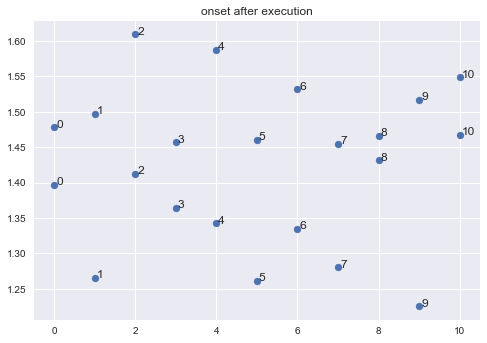

In [42]:
plt.title('onset after execution')
onsets= []
i = 0
for e in episodes_with_two_onsets:
    for o in e.detected_audio_onsets:
        onsets.append((i, (o.header.stamp - e.start_execution).to_sec()))
        #    print(i)
    i+= 1
plt.scatter([i for i,o in onsets], [o for i,o in onsets])
for i, o in onsets:
    plt.text(i+0.05, o, str(i), fontsize=12)

In [43]:
#e = episodes_with_two_onsets[3]

In [44]:
#play_audio(e)

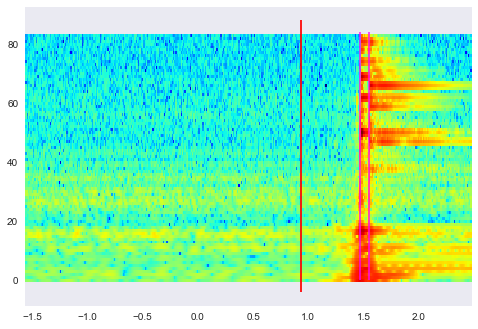

In [45]:
#big_plot()
plot_audio(e)

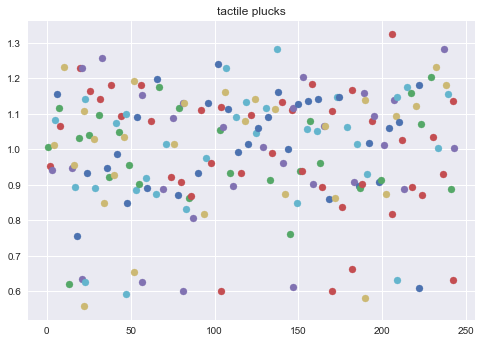

In [46]:
i = 0
plt.figure()
plt.title('tactile plucks')
for e in episodes:
    onsets = []
    for o in e.detected_tactile_plucks:
        onsets.append((o - e.start_execution).to_sec())
    plt.scatter([i] * len(onsets), onsets)
    i+= 1

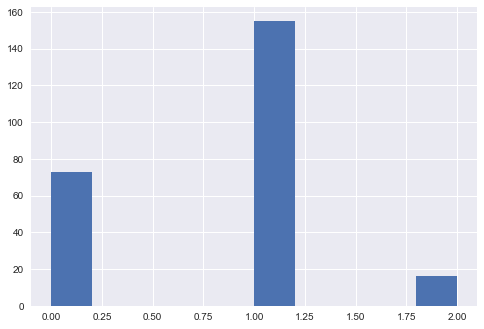

In [47]:
plt.hist([len(e.detected_tactile_plucks) for e in episodes]);

In [48]:
[idx for idx, e in enumerate(episodes) if len(e.detected_tactile_plucks) > 8]

[]

In [49]:
two_tactile_plucks= [e for e in episodes if len(e.detected_tactile_plucks) == 2]
len(two_tactile_plucks)

16

In [50]:
#play_audio(episodes_with_two_onsets[0])

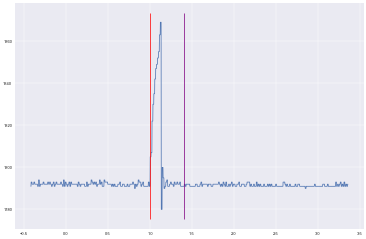

In [51]:
#e = episodes_with_two_onsets[0]
#e = episodes[17]
plt.figure(figsize=(15,10), dpi=30)
plot_tactile(e)

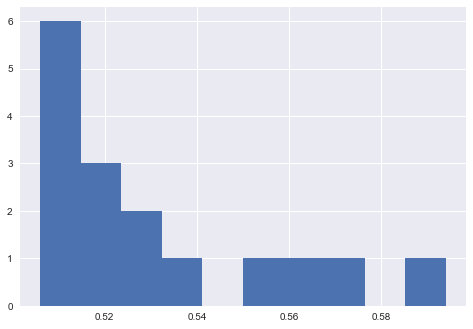

In [52]:
plt.hist([(e.detected_tactile_plucks[1]-e.detected_tactile_plucks[0]).to_sec() for e in two_tactile_plucks]);

In [53]:
len(episodes_with_one_onset)

166

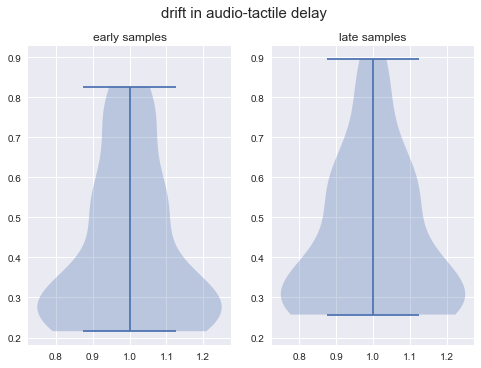

In [54]:
i_early = 50
i_late = len(episodes_with_one_onset)-50

plt.suptitle('drift in audio-tactile delay', fontsize=15)
plt.subplot(1,2,1)
ax = plt.gca()
plt.title('early samples')
plt.violinplot([(e.detected_audio_onsets[0].header.stamp-e.detected_tactile_plucks[0]).to_sec() for i, e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) > 0 and i < i_early]);
plt.subplot(1,2,2, sharey= ax)
plt.title('late samples')
plt.violinplot([(e.detected_audio_onsets[0].header.stamp-e.detected_tactile_plucks[0]).to_sec() for i, e in enumerate(episodes_with_one_onset) if len(e.detected_tactile_plucks) > 0 and i > i_late]);

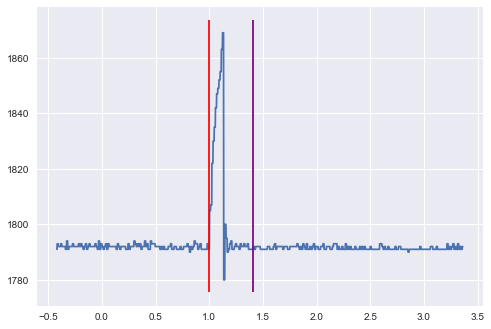

In [55]:
plot_tactile(e)

# next audio onsets:
#nxt_e = episodes[next(idx for idx, e2 in enumerate(episodes) if e2.id == e.id)+1]
#plt.vlines([o.header.stamp.to_sec() for o in nxt_e.detected_audio_onsets], 1500, 2400, 'orange')


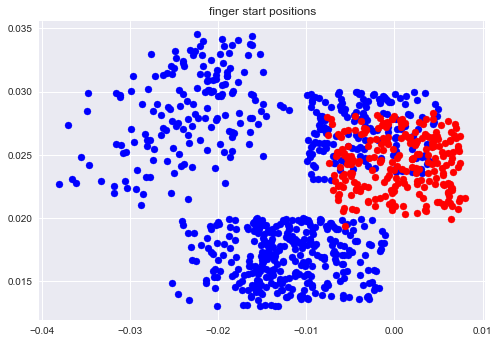

In [56]:
fps= [e.finger_start_pose.pose for e in episodes]
plt.title('finger start positions')
for e in episodes_with_one_onset:
    plt.scatter([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color='b')

plt.scatter([f.position.y for f in fps], [f.position.z for f in fps],  color='r')

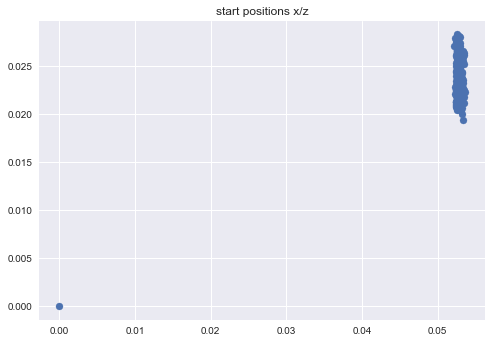

In [57]:
plt.title('start positions x/z')
plt.scatter([f.position.x for f in fps]+[0.0], [f.position.z for f in fps]+[0.0])

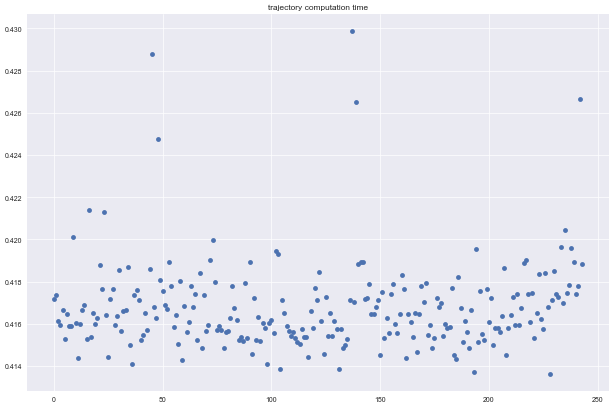

In [58]:
plt.figure(figsize=(15,10), dpi=50)
plt.title('trajectory computation time')
plt.plot([(e.start_execution-e.header.stamp).to_sec() for e in episodes], 'o')

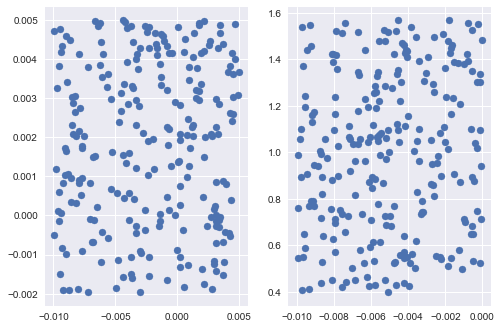

In [59]:
plt.title('action parameters')
plt.subplot(1,2,1)
i= 0
plt.scatter([e.action_parameters.action_parameters[i] for e in episodes], [e.action_parameters.action_parameters[i+1] for e in episodes])
plt.subplot(1,2, 2)
i= 2
plt.scatter([e.action_parameters.action_parameters[i] for e in episodes], [e.action_parameters.action_parameters[i+1] for e in episodes])

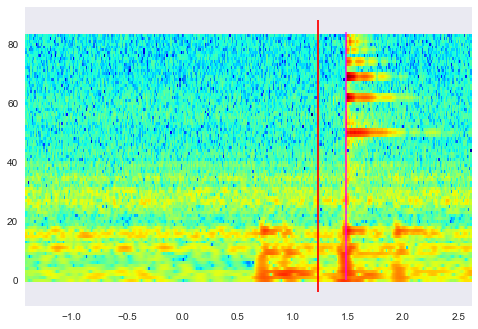

In [60]:
e = episodes_with_one_onset[7]

cqt = cqt_from_episode(e)
plot_audio(e)

In [61]:
print('    cqt start:', e.cqt.header.stamp.to_sec())
print('episode start:', e.header.stamp.to_sec())
print('        onset:', e.detected_audio_onsets[0].header.stamp.to_sec())
print('  episode end:', (e.header.stamp+e.length).to_sec())
print('      cqt end:', (e.cqt.header.stamp + e.cqt.hop_length*cqt.shape[0]).to_sec())

print('   hop length:', e.cqt.hop_length.to_sec())

onset_cqt_idx = int((e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp)/e.cqt.hop_length)
print('onset index: ', onset_cqt_idx)


    cqt start: 1663005924.0838535
episode start: 1663005925.0814936
        onset: 1663005926.9770508
  episode end: 1663005927.0403137
      cqt end: 1663005928.1241255
   hop length: 0.011609977
onset index:  249


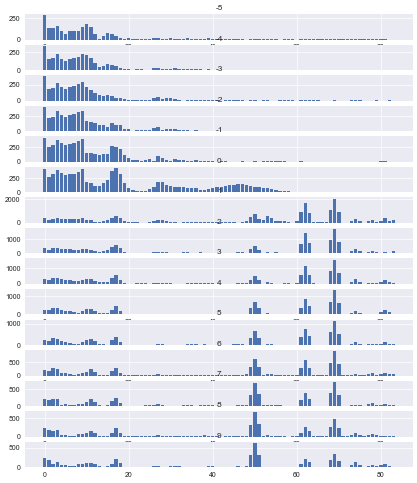

In [62]:
plt.figure(figsize=(10,12),dpi= 50)
for i in range(-5, 10):
    plt.subplot(15,1, i+6)
    plt.title(f'{i}')
    plt.bar(np.arange(0, cqt.shape[1]), cqt[onset_cqt_idx+i,:])

maximum: 69 - should be 50 for note d6


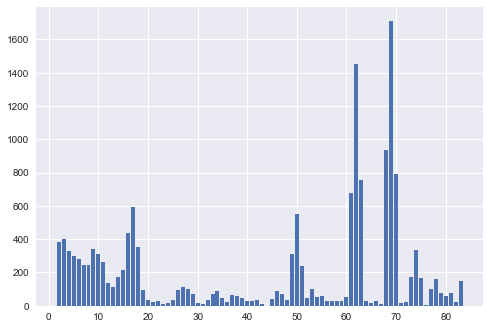

In [63]:
delta= 2
plt.bar(range(2, e.cqt.number_of_semitones), cqt[onset_cqt_idx+delta,2:])

maximum= np.argmax(cqt[onset_cqt_idx+delta,2:])+2
print(f"maximum: {maximum} - should be {note_bucket} for note {note}")

# random test to check whether the defined note_bucket is correct
#assert maximum == note_bucket

In [64]:
onset_cqt_idxs = [int((e.detected_audio_onsets[0].header.stamp-e.cqt.header.stamp)/e.cqt.hop_length) for e in episodes_with_one_onset]

In [65]:
#next(i for i,ee in enumerate(episodes_with_one_onset) if e.id == ee.id)

In [66]:
cqts= [np.array(e.cqt.data).reshape((-1,e.cqt.number_of_semitones)) for e in episodes_with_one_onset]

In [67]:
onset_cqts= np.array([c[i,:] for c, i in zip(cqts, onset_cqt_idxs)])

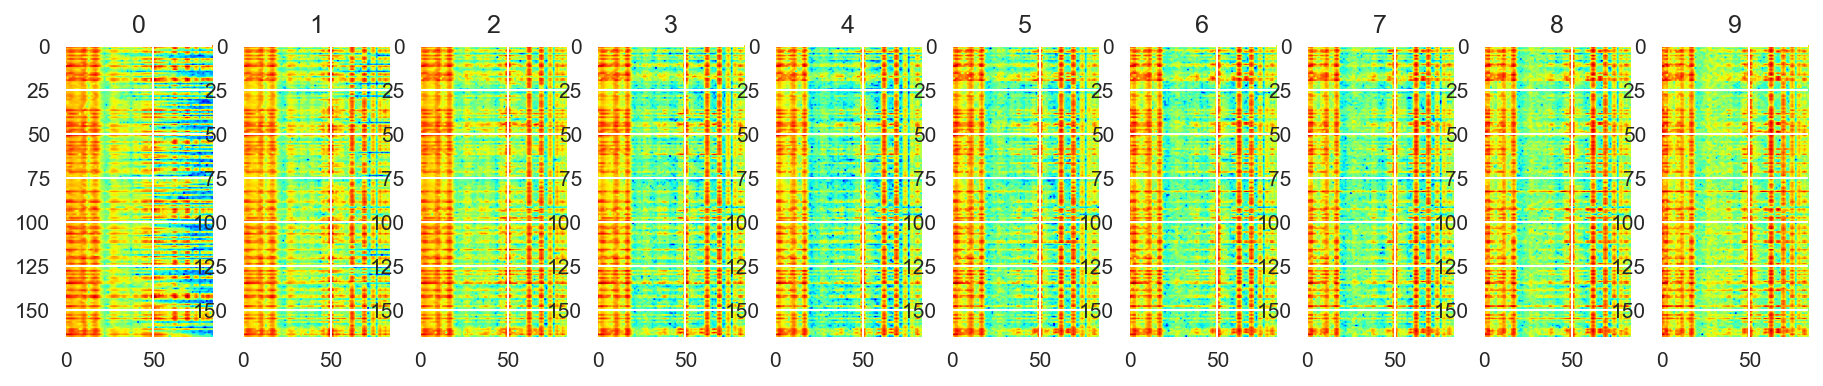

In [68]:
plt.figure(figsize=(15,8),dpi= 150)
shared_ax= None
for i in range(10):
    onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
    shared_ax = plt.subplot(1,10, i+1, sharey= shared_ax)
    plt.title(f'{i}')
    plt.imshow(np.log(onset_cqts), cmap='jet')

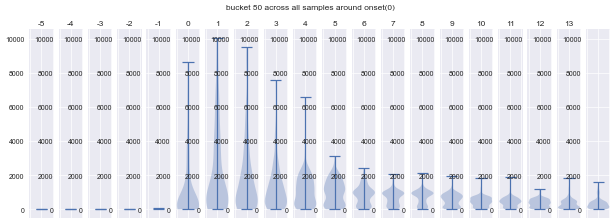

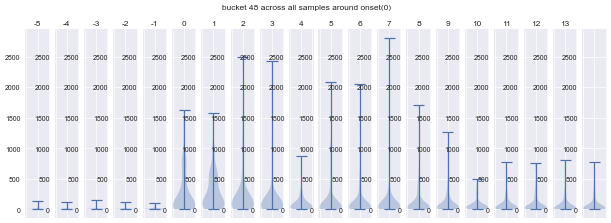

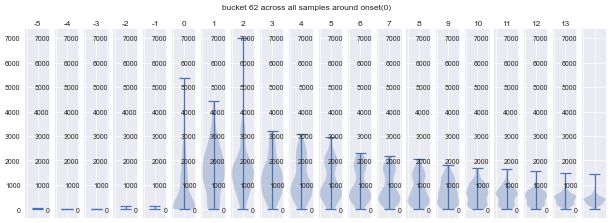

In [69]:
# E5 - 40
for bucket in [note_bucket, note_bucket-2, note_bucket+12]:
    plt.figure(figsize=(15,5),dpi= 50)
    plt.tick_params('y', labelleft=True)
    ax= None
    plt.suptitle(f'bucket {bucket} across all samples around onset(0)')
    subplotidx= 1
    for i in range(-5,15):
        onset_cqts= np.array([c[oi+i,:] for c, oi in zip(cqts, onset_cqt_idxs)])
        ax= plt.subplot(1,20, subplotidx, sharey= ax)
        subplotidx+= 1
        if subplotidx <= 20:
            plt.title(f'{i}')
        plt.tick_params('x', labelbottom=False)
        plt.violinplot(onset_cqts[:,bucket])
        #plt.hist(onset_cqts[:,bucket], orientation= 'horizontal')

In [70]:
note_after_transient = np.array([c[oi+3,note_bucket] for c, oi in zip(cqts, onset_cqt_idxs)])

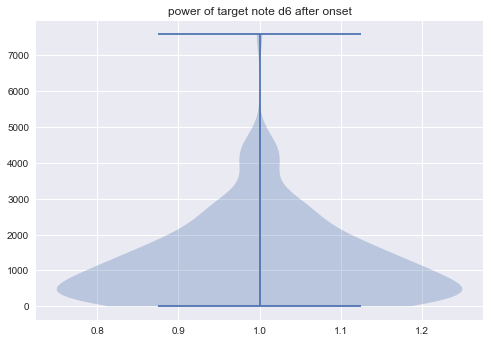

In [71]:
plt.title(f'power of target note {note} after onset')
plt.violinplot(note_after_transient);
plt.savefig(f'power_distribution_over_samples_{note}.png', dpi=150)

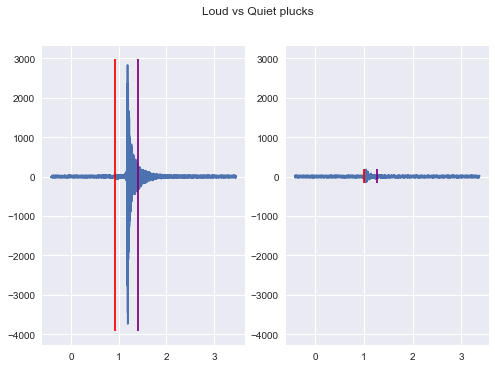

In [72]:
idx_quiet = np.argmin(note_after_transient)
idx_loud = np.argmax(note_after_transient)

plt.suptitle('Loud vs Quiet plucks')
ax= plt.subplot(1,2,1)
plot_raw_audio(episodes_with_one_onset[idx_loud])
plt.subplot(1,2,2, sharey=ax)
plot_raw_audio(episodes_with_one_onset[idx_quiet])

In [73]:
# idx = 0
# for i,v in reversed(sorted(enumerate(note_after_transient), key=lambda v: v[1])[::20][0:16]):
#     play_audio(episodes_with_one_onset[i])
#     print(f"{idx} (of at most 16)")
#     idx+= 1
#     rospy.sleep(rospy.Duration(2.5))

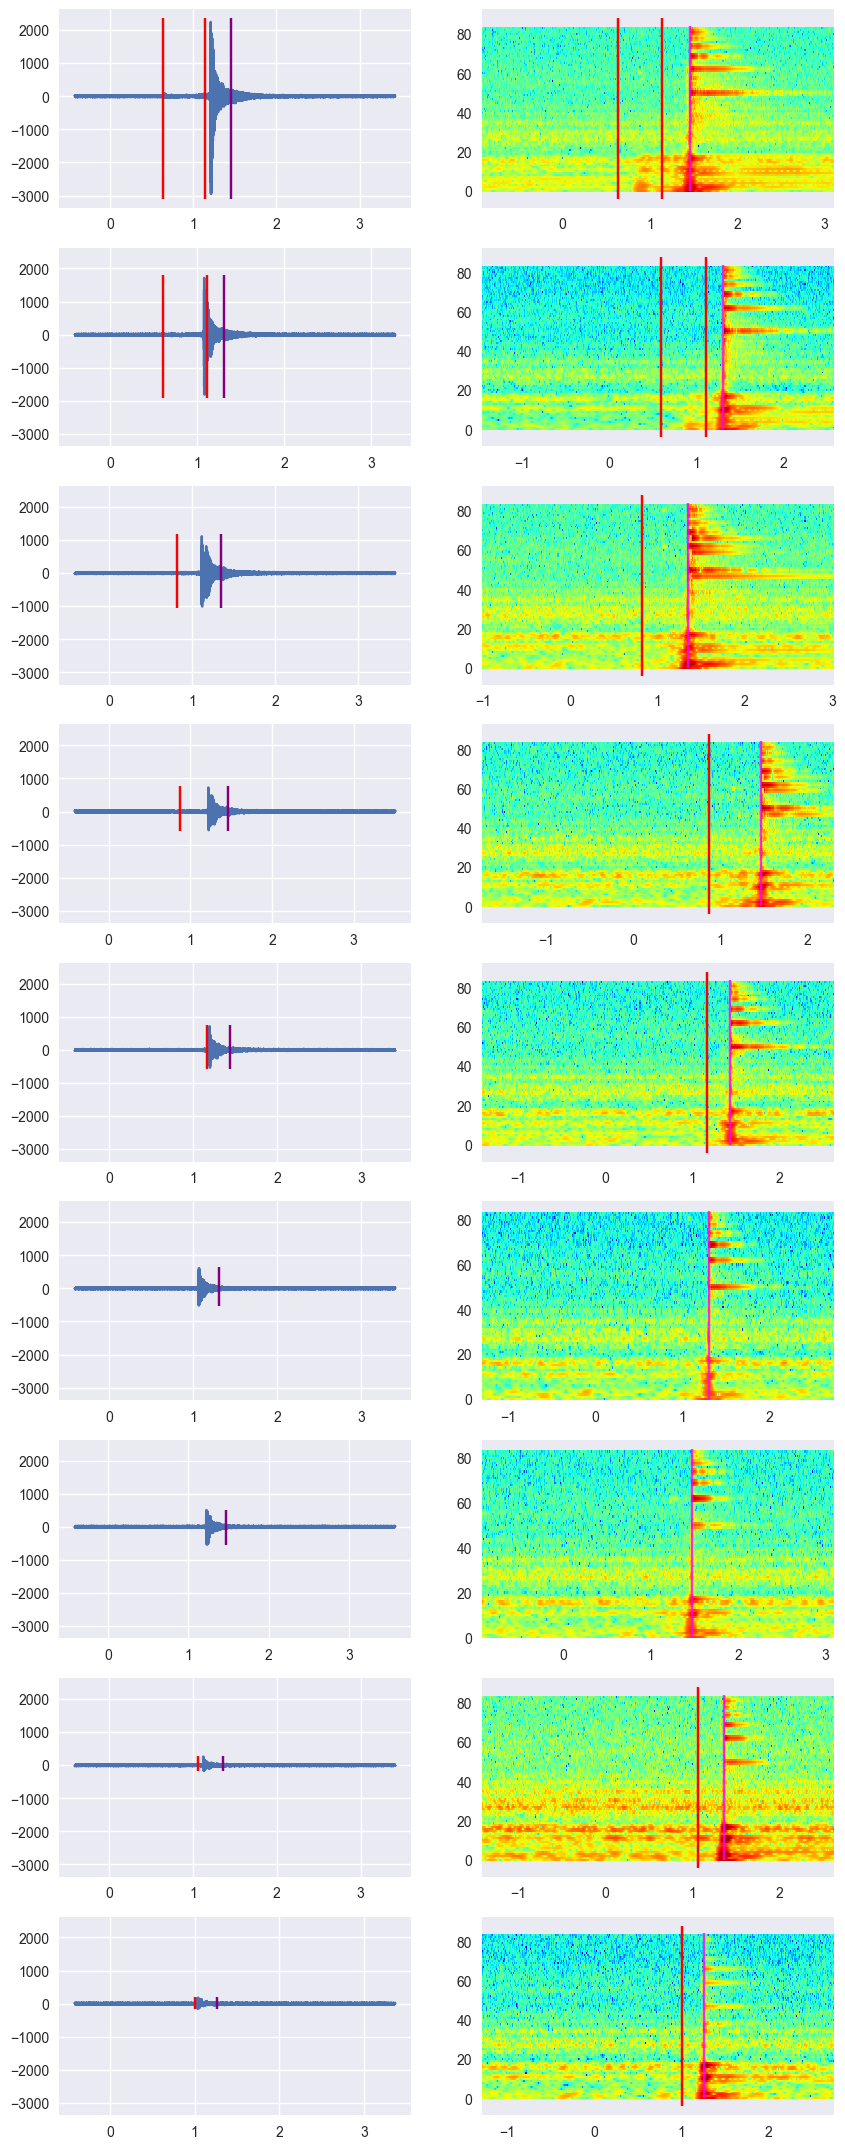

In [74]:
plt.figure(figsize=(10,50), dpi= 100)
idx= 1
ax_audio= None
for i,v in reversed(sorted(enumerate(note_after_transient), key=lambda v: v[1])[::20][0:16]):
    ax_audio = plt.subplot(16,2,idx, sharey= ax_audio)
    idx+= 1
    plot_raw_audio(episodes_with_one_onset[i])
    plt.subplot(16,2,idx)
    idx+= 1
    plot_audio(episodes_with_one_onset[i])

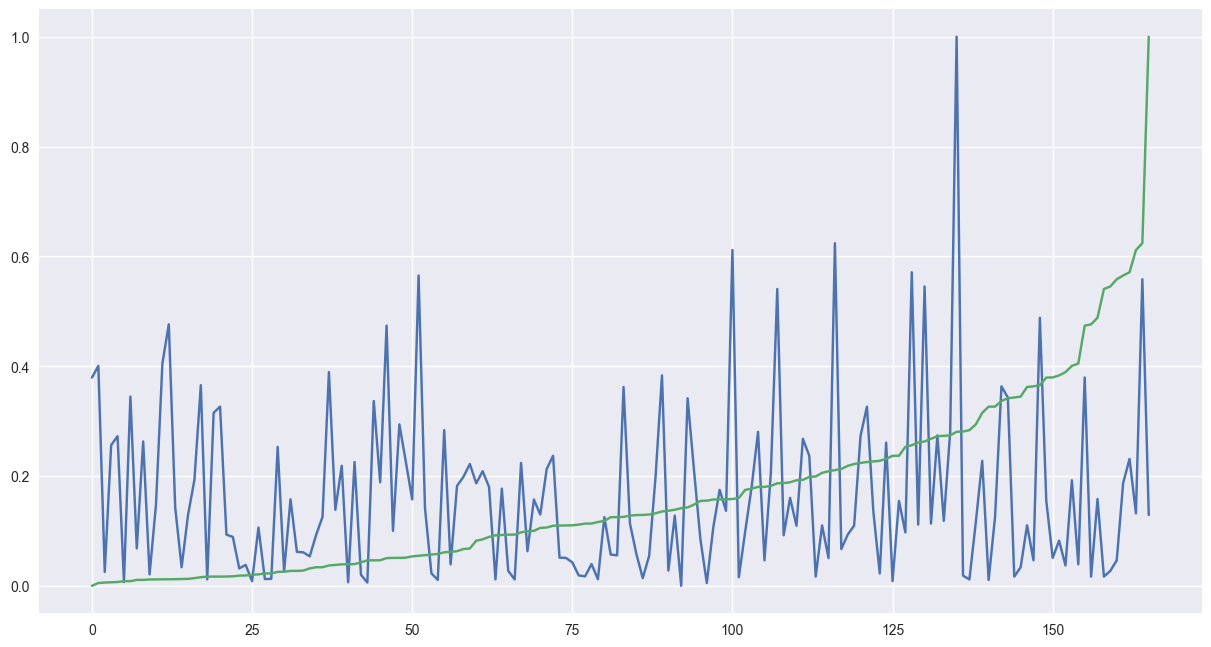

In [75]:
big_plot()
note_after_transient_normalized= note_after_transient/np.max(note_after_transient)
plt.plot(note_after_transient_normalized)
plt.plot(sorted(note_after_transient_normalized))

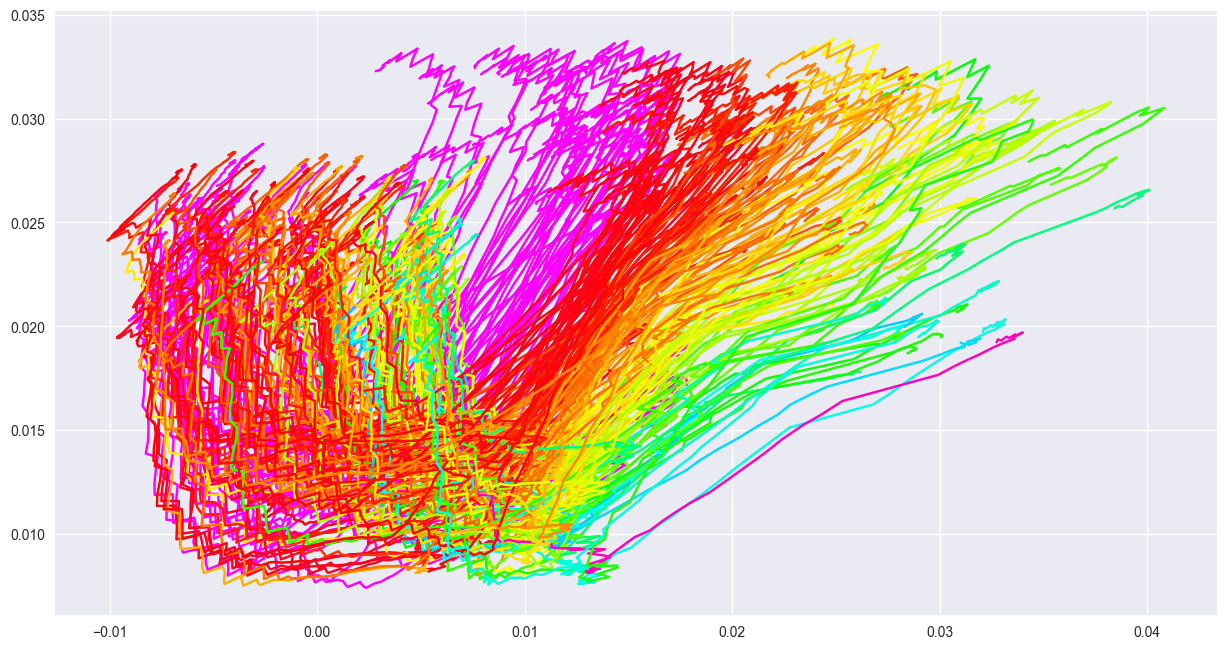

In [76]:
big_plot()

for i, e in enumerate(episodes_with_no_onset):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color= [1.0, 0.0, 1.0, 1.0])

for i, e in enumerate(episodes_with_one_onset):
    plt.plot([-p.pose.position.y for p in e.executed_path.poses], [p.pose.position.z for p in e.executed_path.poses], color= plt.get_cmap('gist_rainbow')(note_after_transient_normalized[i]))
#plt.gca().set_aspect('equal', 'box')
plt.gca().axis('equal')
#plt.title('plucks by power')
#plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=plt.get_cmap('gist_rainbow')))
plt.savefig(f'plucks_by_power_{note}.png', dpi= 150)

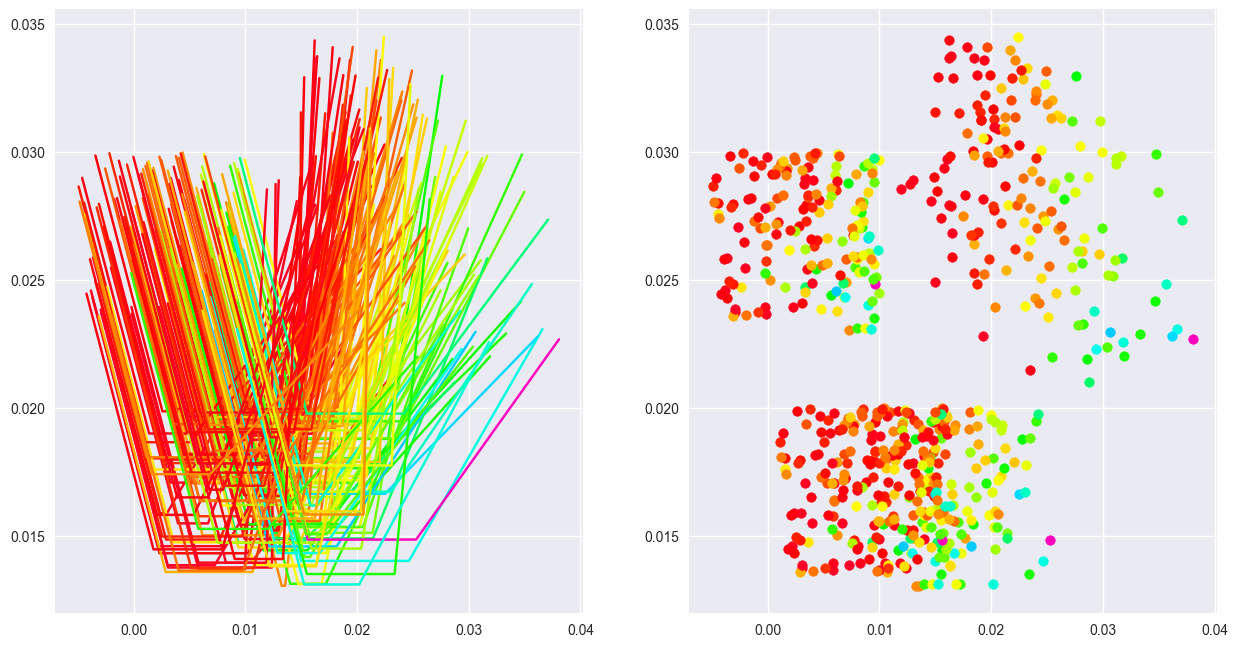

In [77]:
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(1,2,1)
for i,e in enumerate(episodes_with_one_onset):
    plt.plot([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color= plt.get_cmap('gist_rainbow')(note_after_transient_normalized[i]))
plt.subplot(1,2,2)
for i,e in enumerate(episodes_with_one_onset):
    plt.scatter([-p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], color= plt.get_cmap('gist_rainbow')(note_after_transient_normalized[i]))

#plt.suptitle('plucks by power')
plt.savefig(f'cmd_plucks_by_power_{note}.png', dpi=150)
#loud_episodes = [e for i, e in enumerate(episodes_with_one_onset) if note_after_transient[i] > 10000]
#for e in loud_episodes:
#    plt.plot([p.pose.position.y for p in e.commanded_path.poses], [p.pose.position.z for p in e.commanded_path.poses], 'r')

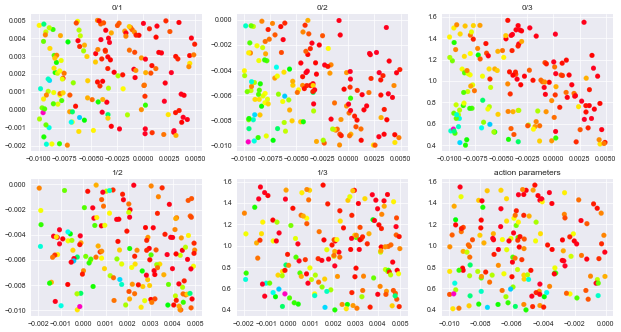

In [78]:
from itertools import combinations

plt.figure(figsize=(15,8), dpi=50)
sidx= 1
for i,j in combinations(range(4), 2):
    plt.subplot(2,3,sidx)
    plt.title(f'{i}/{j}')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    #plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_no_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_no_onset], color='r')

plt.title('action parameters')
plt.savefig(f'action_parameters_by_power_{note}.png', dpi=150)

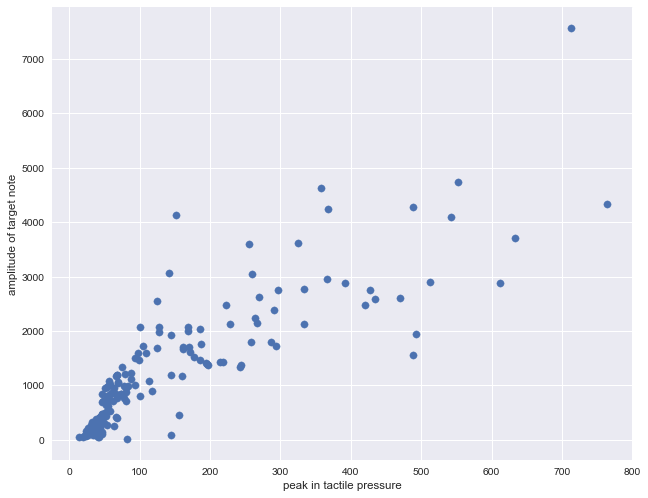

In [82]:
max_pdc_peak = [np.max([t.tactile.pdc for t in e.tactile_data])-e.tactile_data[0].tactile.pdc for e in episodes_with_one_onset]

plt.figure(figsize=(10,8), dpi=75)
plt.scatter(
    max_pdc_peak,
    note_after_transient,
    # would need to be normalized
    #c= plt.get_cmap('jet')([e.action_parameters.action_parameters[0] for e in episodes_with_one_onset])
    )

#plt.plot(np.arange(0,400), model.predict(np.arange(0,400).reshape(-1,1)))
plt.xlabel('peak in tactile pressure')
plt.ylabel('amplitude of target note')
#plt.xlim(0, 800)
plt.savefig(f'amplitude_vs_tactile_{note}', dpi=300)

In [213]:
#from sklearn.linear_model import RANSACRegressor
#
#model = RANSACRegressor(residual_threshold=100, max_trials=1000).fit(np.array(max_pdc_peak).reshape(-1,1),np.array(note_after_transient))


In [159]:
######
######
# Neural Network Playground
######
######

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [246]:
parameter_tensor = F.normalize(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset]), dim=1)
volume_tensor = F.normalize(torch.FloatTensor(note_after_transient), dim=0)

In [247]:
ds= [(parameter_tensor[i,:], volume_tensor[i]) for i in range(len(note_after_transient))]

In [248]:
dl = torch.utils.data.DataLoader(ds, shuffle= True)

In [249]:
# regress volume
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.softmax(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return x

net = Net()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [250]:
for epoch in range(1,101):
    for i, data in enumerate(dl):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'{epoch}')

/home/v4hn/python/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


50
100


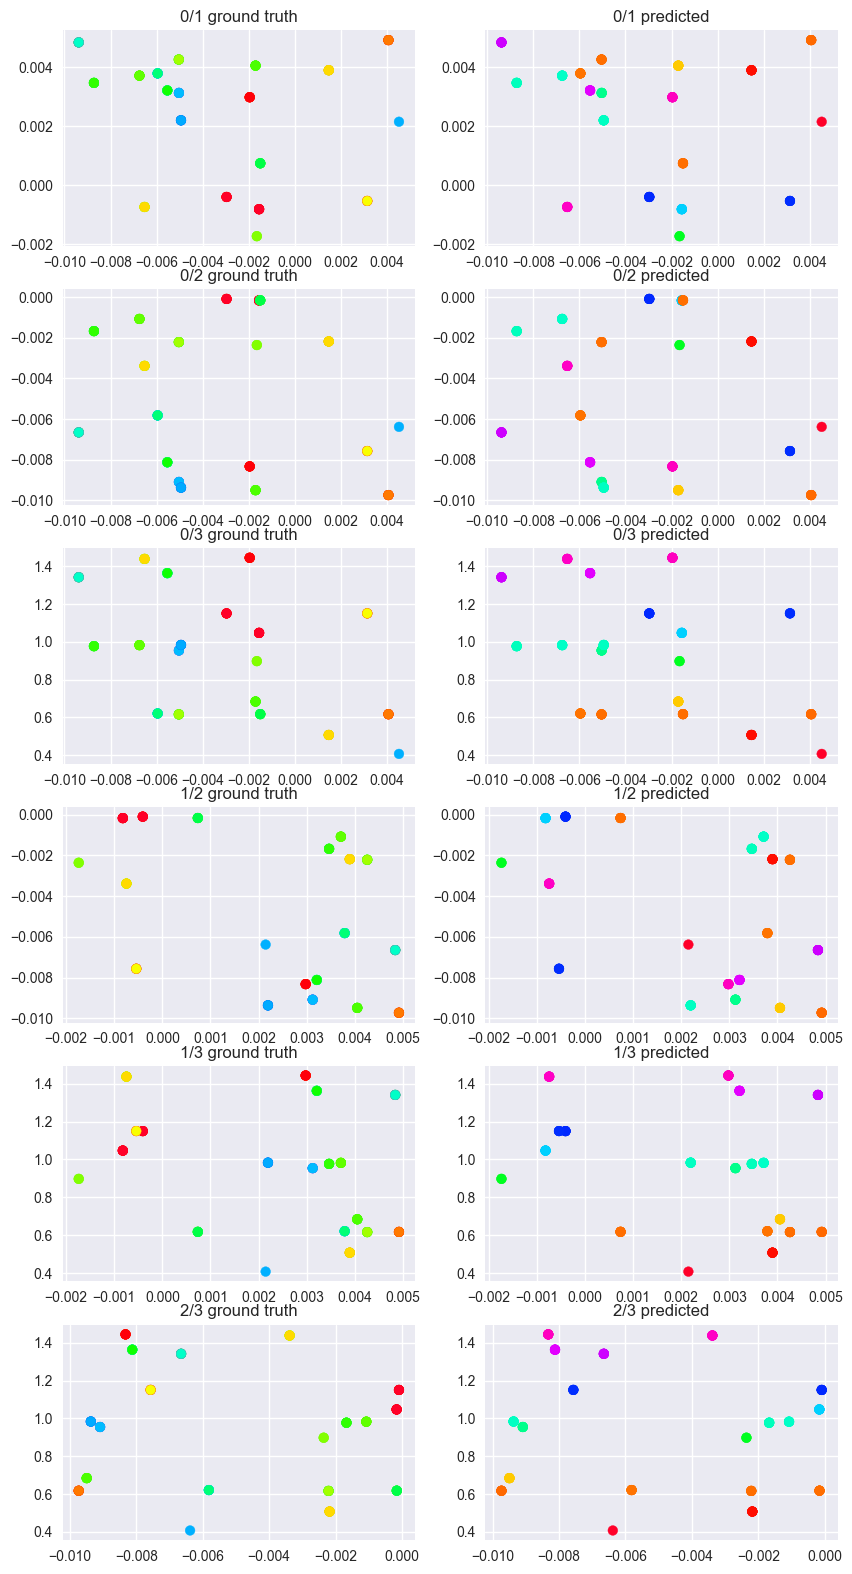

In [251]:
pred = net(torch.FloatTensor([e.action_parameters.action_parameters for e in episodes_with_one_onset])).detach().numpy();
pred.shape

plt.figure(figsize=(10,20), dpi=100)
plt.title('action parameters')
sidx= 1
combs = list(combinations(range(4), 2))
for i,j in combs:
    plt.subplot(len(combs),2,sidx)
    sidx+=1
    plt.title(f'{i}/{j} ground truth')
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=note_after_transient_normalized)
    plt.subplot(len(combs),2,sidx)
    plt.title(f'{i}/{j} predicted')
    sidx+= 1
    plt.scatter([e.action_parameters.action_parameters[i] for e in episodes_with_one_onset], [e.action_parameters.action_parameters[j] for e in episodes_with_one_onset], cmap=plt.get_cmap('gist_rainbow'), c=pred)

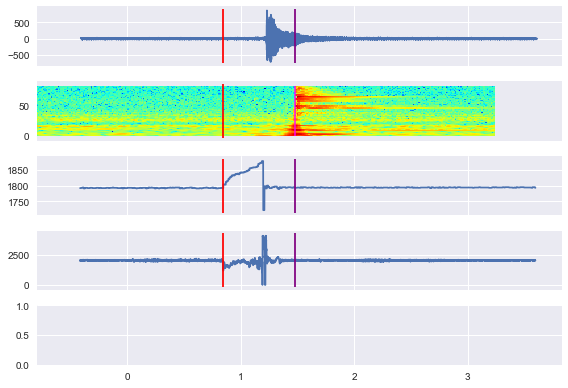

In [252]:
e= episodes_with_one_onset[1]
#plt.figure(dpi=100)
N=5
ax = plt.subplot(N,1,1)
plot_raw_audio(e)
ax = plt.subplot(N,1,2, sharex=ax)
plot_audio(e)
ax = plt.subplot(N,1,3, sharex=ax)
plot_tactile(e)
ax = plt.subplot(N,1,4, sharex=ax)
plot_tactile_ac(e)
ax = plt.subplot(N,1,5, sharex=ax)
#plot_joint(e, "rh_FFJ2")
#plot_joint(e, "rh_FFJ3")
for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()

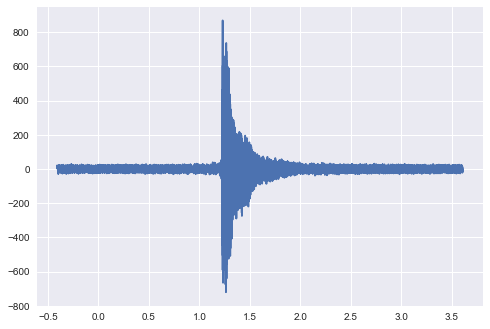

In [253]:
signal = np.array(struct.unpack('{0}h'.format(int(len(e.audio_data.audio.data)/2)), e.audio_data.audio.data), dtype=float)
plt.plot(np.arange(len(signal), dtype=float)/e.audio_info.sample_rate+e.audio_data.header.stamp.to_sec() - e.start_execution.to_sec(), signal)